# Building a custom entity recognizer for PDF documents using Amazon Comprehend

In many industries, it is critical to extract custom entities from documents in a timely manner.  This can be challenging.  Insurance claims, for example, often contain dozens of important attributes (e.g. dates, names, locations, reports) sprinkled across lengthy and dense documents.  Manually scanning and extracting such information is, therefore, error-prone and time-consuming.  Rule-based software can help, but ultimately is too rigid to adapt to the many varying document types and layouts. 

To help automate and speed up this process, Amazon Comprehend can be used to detect custom entities quickly and accurately by leveraging machine learning.  This approach is flexible and accurate, because the system can adapt to new documents by leveraging what it has learned in the past.  Until recently, however, this capability could only be applied to plain text documents which meant that positional information was lost when converting the documents from their native format.  To address this, it was recently announced that Comprehend can now extract custom entities in native PDF and word format.  In this blog post, we will walk through a concrete example from the insurance industry of how you can build a custom recognizer using PDF annotations.

Specifically, we will:
 * Set up IAM permissions to do custom training on Sagemaker 
 * Explore the format of PDF annotations
 * Use the PDF annotations to train a custom model using the Python API
 * Obtain evaluation metrics from the trained model
 * Perform inference on an unseen document

## Getting started

Before training a model, we will need to give SageMaker permission to pass data from Amazon Simple Storage Service (Amazon S3) to AWS Comprehend to run entity recognition jobs.

We will:

    A. Create a new IAM role with an attached policy to read from/write to s3    
    B. Update the role's trust agreement with Comprehend service
    C. Attach a policy to Sagemaker that will pass along the role to Comprehend when asked


In [ ]:
# Enter your AWS ACCOUNT ID
AWS_ACCOUNT_ID = <Insert yout AWS_ACCOUNT_ID HERE>

**A. Create a new IAM role with an attached policy to read from/write to s3**

1. Create new IAM role, choose EC2 use-case
2. Create a new policy (opens new tab), with following JSON code (execute cell and copy result), and call it "policy-rk-read-write"
3. Go back to creating new IAM role (previous tab), refresh policy policy list, and attach "policy-rk-read-write"
4. Name role "comprehends3access"
5. Create a private s3 bucket s3://my-custom-comprehend-output-{AWS_ACCOUNT_ID}, to capture output from your detection job

In [ ]:
import json

j = {
    "Statement": [
        {
            "Action": [
                "s3:ListBucket"
            ],
            "Effect": "Allow",
            "Resource": [
                "arn:aws:s3:::ee-assets-prod-us-east-1",
                f"arn:aws:s3:::my-custom-comprehend-output-{AWS_ACCOUNT_ID}/*"
            ]
        },
        {
            "Action": [
                "s3:PutObject",
                "s3:DeleteObject"
            ],
            "Effect": "Allow",
            "Resource": [
                f"arn:aws:s3:::my-custom-comprehend-output-{AWS_ACCOUNT_ID}/*"
            ]
        },
        {
            "Action": [
                "s3:GetObject"
            ],
            "Effect": "Allow",
            "Resource": [
                "arn:aws:s3:::ee-assets-prod-us-east-1/*"
            ]
        }
    ],
    "Version": "2012-10-17"
}

print(json.dumps(j, indent=4, sort_keys=True))


**B. Update the role's trust agreement with Comprehend service**

1. Navigate to "comprehends3access" role
2. Edit trust relationship
3. Replace EC2 with Comprehend for the Service field: "comprehend.amazonaws.com"

**C. Attach a policy to Sagemaker that will pass along the role to Comprehend when asked**

1. Create new policy, using JSON below (execute and copy)
2. Name the policy "IAMPassPolicyComprehend"
3. Navigate to the AmazonSageMaker-ExecutionRole-XXXX role, add permissions, and attach this policy
4. Also add "ComprehendFullAccess" and "AmazonTextractFullAccess" policies to the this role

In [ ]:
j = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "ComprehendAsyncPass",
            "Effect": "Allow",
            "Action": "iam:PassRole",
            "Resource": "arn:aws:iam::{}:role/comprehends3access".format(AWS_ACCOUNT_ID)
            
        }
    ]
}

print(json.dumps(j, indent=4, sort_keys=True))

In [ ]:
# Imports
%load_ext autoreload
%autoreload 2
from pprint import pprint
import os
import sys
import json
import boto3
import time
import uuid
import pandas as pd
module_path = os.path.join(os.path.abspath(os.path.join('.')), 'helperPackage')
if module_path not in sys.path:
    sys.path.append(module_path)
from pdfhelper.PDFHelper import PDFHelper
from IPython.display import IFrame
!pip install --upgrade pymupdf

def split_s3_uri(uri):
    """return (bucket, key) tuple from s3 uri like 's3://bucket/prefix/file.txt' """
    return uri.replace('s3://','').split('/',1)

def s3_object_from_uri(uri):
    """Initialize a boto3 s3 Object instance from a URI"""
    s3 = boto3.resource('s3')
    return s3.Object(*split_s3_uri(uri))

def s3_contents_from_uri(uri, decode=True):
    """Read contents from S3 object into memory"""
    data = s3_object_from_uri(uri).get()['Body'].read()
    return data.decode() if decode else data

def s3_download_file(s3_uri, localpath):
    """Download file from s3"""
    s3 = boto3.client('s3')
    bucket, key = split_s3_uri(s3_uri)
    s3.download_file(bucket, key, localpath)
    
def split_s3_uri(s3_uri):
    """Split url into bucket and key"""
    bucket, key = s3_uri.replace("s3://", "").split("/", 1)
    return bucket, key

comprehend = boto3.client('comprehend')

In [ ]:
# Set up paths
ASSETS_S3_PREFIX = 's3://ee-assets-prod-us-east-1/modules/b2d6c897c659445583c2edb826183e8e/v1/'

# Information about the training data and how the SageMaker Ground Truth job output looks in S3
TRAINING_DOCS_S3_URI_PREFIX = os.path.join(ASSETS_S3_PREFIX, 'documents/')
ANNOTATIONS_S3_URI_PREFIX = os.path.join(ASSETS_S3_PREFIX, 'annotations/annotations/consolidated-annotation/consolidation-response/iteration-1/annotations/')
MANIFEST_S3_URI = os.path.join(ASSETS_S3_PREFIX, 'annotations/manifests/output/output.manifest')
LABEL_ATTRIBUTE_NAME = 'claim-full-job-labeling-job-20211019T163532'

# local directory containing data reference in this notebook
LOCAL_ARTIFACTS_DIR = 'ComprehendCustom-Artifacts'
# local path to store results in
LOCAL_OUTPUT_DIR = 'tmp/ComprehendCustom'
# set up tmp dir under the working directory
!mkdir -p {LOCAL_OUTPUT_DIR}

# Download some files for later
# Raw PDFs
!mkdir -p {LOCAL_ARTIFACTS_DIR}/ex_pdfs
fnames = ['INSR_ACORD-Property-Loss-Notice-12.05.16_1_pii_00000.pdf', 'INSR_ACORD-Property-Loss-Notice-12.05.16_1_pii_00017.pdf', 'INSR_pm_hipaa_1_pii_00048.pdf']
for fname in fnames:
    s3_download_file(os.path.join(TRAINING_DOCS_S3_URI_PREFIX, fname), f'{LOCAL_ARTIFACTS_DIR}/ex_pdfs/{fname}')

Now that we have set things up, we can train our model to detect the following five entities that we chose because of their relevance to insurance claims: DateOfForm, DateOfLoss, NameOfInsured, LocationOfLoss, and InsuredMailingAddress

## Explore the format of PDF annotations

To create annoations for PDF documents, you can use [Amazon SageMaker GroundTruth](https://aws.amazon.com/sagemaker/groundtruth/) - a fully managed data labeling service that makes it easy to build highly accurate training datasets for machine learning.

For this tutorial, we have already annotated the PDFs, in their native form (i.e. without converting to plain text) using SageMaker GroundTruth. (To set up your own annotation job, refer to the resources in the **Summary/Resources** section of this notebook)

The Ground Truth job generates three paths we will need for training our Comprehend custom model.
1. Sources: Path to the input PDFs
2. Annotations: Path to the annotation jsons containing the labeled entity information
3. Manifest: Points to the location of the annotations and source PDFs.  You will use this manifest file to create an Amazon Comprehend custom entity recognition training job and train your custom model.  Manifests are saved in s3://comprehend-semi-structured-documents-us-east-1--<AWS Account number>/output/your labeling job/manifests/output/

In [ ]:
# Let's have a look at a sample annotation

# We will find the line of the manifest corresponding to a particular input document
document_s3_uri = os.path.join(ASSETS_S3_PREFIX, 'documents','INSR_ACORD-Property-Loss-Notice-12.05.16_1_pii_00000.pdf')

manifest_data = [json.loads(obj) for obj in s3_contents_from_uri(MANIFEST_S3_URI).splitlines()]

manifest_line = [r for r in manifest_data if r['source-ref']==document_s3_uri][0]
# manifest_line

# Let's download the annotation file and look at a sample annotation

annotations_uri = manifest_line[LABEL_ATTRIBUTE_NAME]['annotation-ref']

annotations = json.loads(s3_contents_from_uri(annotations_uri))
annotations['Entities'][0]

## Uncomment the following line to see more of the annotated entities:
# annotations['Entities']

As you can see above, the custom GroundTruth job generates a PDF annotation that captures block-level information about the entity.  Such block-level information provides the precise positional coordinates of the entity (with the child blocks representing each word within the entity block).  This is distinct from a standard GroundTruth job in which the data in the PDF is flattened to textual format and only offset information - but not precise coordinate information - is captured during annotation.  The rich positional information we obtain with this custom annotation paradigm will allow us to train a more accurate model. 

The manifest that's generated from this type of job is called an Augmented Manifest, as opposed to a CSV that's used for standard annotations. For more information, see: https://docs.aws.amazon.com/comprehend/latest/dg/cer-annotation.html



In [ ]:
# Visualize the annotated pdf inline

original_file = f'{LOCAL_ARTIFACTS_DIR}/ex_pdfs/INSR_ACORD-Property-Loss-Notice-12.05.16_1_pii_00000.pdf'
annotated_file = f'{LOCAL_OUTPUT_DIR}/annotated.pdf'

# using a custom module (PDFHelper) to add annotations the file before displaying
PDFHelper.add_annotations_to_file(annotations, original_file, annotated_file)
IFrame(annotated_file, width=600, height=800)

# Note: you may need to zoom in to read the label names

In [ ]:
# Lets look at another annotated sample

# changed the document s3 uri
document_s3_uri = os.path.join(ASSETS_S3_PREFIX, 'documents','INSR_pm_hipaa_1_pii_00048.pdf')

# get the annotations data
manifest_data = [json.loads(obj) for obj in s3_contents_from_uri(os.path.join(ASSETS_S3_PREFIX, 'annotations/manifests/output/output.manifest')).splitlines()]
manifest_line = [r for r in manifest_data if r['source-ref']==document_s3_uri][0]
annotations_uri = manifest_line[LABEL_ATTRIBUTE_NAME]['annotation-ref']
annotations = json.loads(s3_contents_from_uri(annotations_uri))

original_file = f'{LOCAL_ARTIFACTS_DIR}/ex_pdfs/INSR_pm_hipaa_1_pii_00048.pdf'
annotated_file =f'{LOCAL_OUTPUT_DIR}/INSR_pm_hipaa_1_pii_00048_annotated.pdf'

# using a custom module (PDFHelper) to add annotations the file before displaying
PDFHelper.add_annotations_to_file(annotations, original_file, annotated_file)
IFrame(annotated_file, width=600, height=800)

# Use the PDF annotations to train a custom model using the Python API

An augmented manifest file must be formatted in JSON Lines format. In JSON Lines format, each line in the file is a complete JSON object followed by a newline separator.

In [ ]:
# Let's have a look at an entry within this augmented manifest file.
manifest_line

A few things to note:

* There are 5 labeling types associated with this job: DateOfForm, DateOfLoss, NameOfInsured, LocationOfLoss, and InsuredMailingAddress
* The manifest file makes reference to both the source PDF location and the annotation location
* Metadata about the annotation job (e.g. creation date) is captured.
* Use-textract-only is set to False, meaning the annotation tool will decide whether to use PDFPlumber (for a native PDF) or Amazon Textract (for a scanned PDF). If it were set to true, textract would be used in either case (more costly but potentially more accurate).  

In [ ]:
# Now we can train the recognizer

comprehend = boto3.client('comprehend')
response = comprehend.create_entity_recognizer(
    RecognizerName="recognizer-example-{}".format(str(uuid.uuid4())),
    LanguageCode="en",
    DataAccessRoleArn=f'arn:aws:iam::{AWS_ACCOUNT_ID}:role/comprehends3access',
    InputDataConfig={
        "DataFormat": "AUGMENTED_MANIFEST",
        "EntityTypes": [
            {
                "Type": "DateOfForm"
            },
            {
                "Type": "DateOfLoss"
            },
            {
                "Type": "NameOfInsured"
            },
            {
                "Type": "LocationOfLoss"
            },
            {
                "Type": "InsuredMailingAddress"
            }
        ],
        "AugmentedManifests": [
            {
                'S3Uri': MANIFEST_S3_URI,
                'AnnotationDataS3Uri': ANNOTATIONS_S3_URI_PREFIX,
                'SourceDocumentsS3Uri': TRAINING_DOCS_S3_URI_PREFIX,
                'AttributeNames': [LABEL_ATTRIBUTE_NAME],
                'DocumentType': 'SEMI_STRUCTURED_DOCUMENT',
            }
        ],
    }
)
recognizer_arn = response["EntityRecognizerArn"]
recognizer_arn

Here, we are creating a recognizer to recognize all five types of entities.  Of course, we could have used a subset of these entities if we preferred.  You can use up to 25 entities. 

The details of each parameter are given below (source: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/comprehend.html#Comprehend.Client.create_entity_recognizer)

**DataFormat (string) --**

The format of your training data:

COMPREHEND_CSV : A CSV file that supplements your training documents. The CSV file contains information about the custom entities that your trained model will detect. The required format of the file depends on whether you are providing annotations or an entity list. If you use this value, you must provide your CSV file by using either the 
Annotations or EntityList parameters. You must provide your training documents by using the Documents parameter.

AUGMENTED_MANIFEST : A labeled dataset that is produced by Amazon SageMaker Ground Truth. This file is in JSON lines format. Each line is a complete JSON object that contains a training document and its labels. Each label annotates a named entity in the training document. If you use this value, you must provide the AugmentedManifests parameter in your request.
If you don't specify a value, Amazon Comprehend uses COMPREHEND_CSV as the default.

**EntityTypes (list) -- [REQUIRED]**

The entity types in the labeled training data that Amazon Comprehend uses to train the custom entity recognizer. Any entity types that you don't specify are ignored.

A maximum of 25 entity types can be used at one time to train an entity recognizer.

**S3Uri (string) -- [REQUIRED]**

The Amazon S3 location of the augmented manifest file.

**AnnotationDataS3Uri (string) --**

The S3 prefix to the annotation files that are referred in the augmented manifest file.

**SourceDocumentsS3Uri (string) --**

The S3 prefix to the source files (PDFs) that are referred to in the augmented manifest file.

**AttributeNames (list) -- [REQUIRED]**

The JSON attribute that contains the annotations for your training documents. The number of attribute names that you specify depends on whether your augmented manifest file is the output of a single labeling job or a chained labeling job.

If your file is the output of a single labeling job, specify the LabelAttributeName key that was used when the job was created in Ground Truth.

If your file is the output of a chained labeling job, specify the LabelAttributeName key for one or more jobs in the chain. Each LabelAttributeName key provides the annotations from an individual job.

**DocumentType (string) --**

The type of augmented manifest. PlainTextDocument or SemiStructuredDocument. If you don't specify, the default is PlainTextDocument.

PLAIN_TEXT_DOCUMENT A document type that represents any unicode text that is encoded in UTF-8.

SEMI_STRUCTURED_DOCUMENT A document type with positional and structural context, like a PDF. For training with Amazon Comprehend, only PDFs are supported. For inference, Amazon Comprehend support PDFs, DOCX and TXT.

In [ ]:
# Depending on the size of the training set, training time can vary.  
# For this dataset, training will take ~1 hour. 
# Let's check on the status of the submitted training job

# All recognizers
recognizers = comprehend.list_entity_recognizers()
# View the last submitted job
recognizers['EntityRecognizerPropertiesList'][-1]

In [ ]:
# To monitor the status of the training job, you can use the describe_entity_recognizer API.
# Check status of custom model training periodically until complete.

recognizer_arn = recognizers['EntityRecognizerPropertiesList'][-1]['EntityRecognizerArn']

while True:
    response = comprehend.describe_entity_recognizer(
        EntityRecognizerArn=recognizer_arn
    )

    status = response["EntityRecognizerProperties"]["Status"]
    if "IN_ERROR" == status:
        print('TRAINING ERROR')
        break
    if "TRAINED" == status:
        print('TRAINING COMPLETE')
        break
    print(status)
    time.sleep(60)

## Obtain evaluation metrics from the trained model

Comprehend provides model performance metrics for a trained model, which indicates how well the trained model is expected to make predictions using similar inputs.  We can obtain both global precision/recall metrics as well as per-entity metrics.  An accurate model will have both high precision and recall.  High precision means the model is usually correct when it indicates a particular label, while high recall means that the model found most of the labels.  F1 is a composite metric (harmonic mean) of these measures, and is thus high when both components are high. For a detailed description of the metrics, see: https://docs.aws.amazon.com/comprehend/latest/dg/cer-metrics.html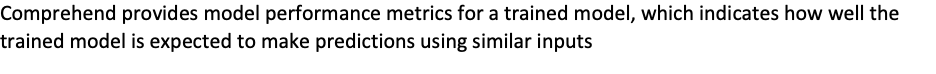

In [ ]:
trained_recognizer_arn = recognizers['EntityRecognizerPropertiesList'][-1]['EntityRecognizerArn']
trained_recognizer = comprehend.describe_entity_recognizer(EntityRecognizerArn=trained_recognizer_arn)

# Global evaluation metrics
trained_recognizer['EntityRecognizerProperties']['RecognizerMetadata']['EvaluationMetrics']

In [ ]:
# Per entity metrics
entity_metrics = trained_recognizer['EntityRecognizerProperties']['RecognizerMetadata']['EntityTypes']
for entity in entity_metrics:
    print(entity['Type'])
    print(entity['EvaluationMetrics'])
    print()

## Perform inference on an unseen document

Let's run inference with our trained model on a document that was not part of the training procedure.  This asynchrnous API can be used for standard or custom NER.  If it is being used for custom NER (as it is here) we must pass the ARN of the trained model.

In [ ]:
# Start entities detection job

response = comprehend.start_entities_detection_job(
    EntityRecognizerArn=trained_recognizer_arn,
    JobName="Detection-Job-{}".format(str(uuid.uuid4())),
    LanguageCode="en",
    DataAccessRoleArn=f'arn:aws:iam::{AWS_ACCOUNT_ID}:role/comprehends3access',
    InputDataConfig={
        "InputFormat": "ONE_DOC_PER_FILE",
        "S3Uri": os.path.join(ASSETS_S3_PREFIX, 'holdout/')
    },
    OutputDataConfig={
        "S3Uri": f's3://my-custom-comprehend-output-{AWS_ACCOUNT_ID}/'
    }
)
response

**S3Uri (string) -- [REQUIRED]**
    The Amazon S3 URI for the input data. The URI must be in same region as the API endpoint that you are calling. The URI can point to a single input file or it can provide the prefix for a collection of data files.

    For example, if you use the URI S3://bucketName/prefix , if the prefix is a single file, Amazon Comprehend uses that file as input. If more than one file begins with the prefix, Amazon Comprehend uses all of them as input.

**InputFormat (string) --**
    Specifies how the text in an input file should be processed:

    ONE_DOC_PER_FILE - Each file is considered a separate document. Use this option when you are processing large documents, such as newspaper articles or scientific papers.
    ONE_DOC_PER_LINE - Each line in a file is considered a separate document. Use this option when you are processing many short documents, such as text messages.

**Waiting for detection job completion**

This code snippet could be used to periodically check the status of your detection job and wait until it finishes.

We've already done a detection with a previously trained model so we will take a look at those results instead of using this code to wait for the job to finish, which would take a few minutes.

```
while True:
    job = comprehend.describe_entities_detection_job(
        JobId=response['JobId']
    )
    
    status = job["EntitiesDetectionJobProperties"]["JobStatus"]
    if "IN_ERROR" == status:
        print('DETECTION ERROR')
        break
    if "COMPLETED" == status:
        print('DETECTION COMPLETE')
        break
    print(status)
    time.sleep(60)
```

In [ ]:
# Get the output from the detection job

# download pre-generated inference output for INSR_ACORD-Property-Loss-Notice-12.05.16_1_pii_00017
!mkdir -p {LOCAL_ARTIFACTS_DIR}/inference_output
INFERENCE_RESULTS_S3_URI = os.path.join(ASSETS_S3_PREFIX, 'detection/output/output.tar.gz')
# If you want to instead use the result from the detection job after it completes, uncomment this line: 
# INFERENCE_RESULTS_S3_URI= comprehend.describe_entities_detection_job(JobId=response['JobId'])['EntitiesDetectionJobProperties']['OutputDataConfig']['S3Uri']

# Pre-computed inference output (will have option to use this, or remake inference output)
s3_download_file(INFERENCE_RESULTS_S3_URI, f'{LOCAL_ARTIFACTS_DIR}/inference_output/output.tar.gz')

# Detection job output is at {LOCAL_ARTIFACTS_DIR}/inference_output/output.tar.gz
!mkdir -p {LOCAL_OUTPUT_DIR}/inference_output/
!tar -xvzf {LOCAL_ARTIFACTS_DIR}/inference_output/output.tar.gz -C {LOCAL_OUTPUT_DIR}/inference_output/

INFERENCE_RESULTS_PATH = os.path.join(LOCAL_OUTPUT_DIR, 'inference_output/INSR_ACORD-Property-Loss-Notice-12.05.16_1_pii_00017_NativePDF.out')

In [ ]:
# Let's look at the inference on an example document
INFERENCE_RESULTS_PATH = os.path.join(LOCAL_OUTPUT_DIR, 'inference_output/INSR_ACORD-Property-Loss-Notice-12.05.16_1_pii_00017_NativePDF.out')

with open(INFERENCE_RESULTS_PATH) as f:
    detection_output = json.load(f)

entities_list = detection_output['Entities']

pd.DataFrame(entities_list)

In [ ]:
# Note that the model prediction output format closely resembles the annotation output format shown above.
entities_list[0]

In [ ]:
# Let's visualize the the labels predicted by our model for this new example pdf

holdout_pdf = f'{LOCAL_ARTIFACTS_DIR}/ex_pdfs/INSR_ACORD-Property-Loss-Notice-12.05.16_1_pii_00017.pdf'
annotated_file =f'{LOCAL_OUTPUT_DIR}/detection_annotated.pdf'
PDFHelper.add_annotations_to_file(detection_output, holdout_pdf, annotated_file)
IFrame(annotated_file, width=600, height=800)

## 7. Summary

In addition to the standard set of entities recognized by Amazon Comprehend's standard entity detection capabilities, Comprehend enables you to train and use your own custom models for detecting user-defined entities specific to your business use case directly on PDF documents.  In this notebook you used a dataset of PDFs annotated with SageMaker Ground Truth to train a entity detection model in Comprehend.

### Resources

- Here are additional resources to help you dive deeper:

 - Setting up your own custom annotation job: https://aws.amazon.com/blogs/machine-learning/custom-document-annotation-for-extracting-named-entities-in-documents-using-amazon-comprehend/

 - Training a custom NER model using the Comprehend console: https://aws.amazon.com/blogs/machine-learning/extract-custom-entities-from-documents-in-their-native-format-with-amazon-comprehend/

 - API reference: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/comprehend.
